<a href="https://colab.research.google.com/github/Jesus2342/Advanced_ML_Methods-/blob/main/A4_DL_TC5033_Transformer_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team 52
### Anghelo Daniel Pérez Martínez (A01795323)
### José de Jesús Peña Rodríguez (A01794940)
### Luis Daniel Ortega Muñoz (A01795197)
### Gerardo Miguel Pérez Solis (A01795599)
### Emil Khaleb Palomino Bruzzón (A00826811)

# TC 5033
# **Deep Learning**
# **Transformers**

#### Activity 4: Implementing a Translator

- Objective

To understand the Transformer Architecture by Implementing a translator.

- Instructions

    This activity requires submission in teams. While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Follow the provided code. The code already implements a transformer from scratch as explained in one of [week's 9 videos](https://youtu.be/XefFj4rLHgU)

    Since the provided code already implements a simple translator, your job for this assignment is to understand it fully, and document it using pictures, figures, and markdown cells.  You should test your translator with at least 10 sentences. The dataset used for this task was obtained from [Tatoeba, a large dataset of sentences and translations](https://tatoeba.org/en/downloads).
  
- Evaluation Criteria

    - Code Readability and Comments
    - Traning a translator
    - Translating at least 10 sentences.

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.



**Connect to local Drive**

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Script to convert csv to text file**

In [ ]:
#This script requires to convert the TSV file to CSV
# easiest way is to open it in Calc or excel and save as csv
PATH = '/content/drive/MyDrive/pytorch/activity_4/Spa_Eng_sentencesD.csv'
import pandas as pd
df = pd.read_csv(PATH, encoding='latin1', on_bad_lines='skip')

Process the dataframe and output a txt file, the format will be different,
it will remove the numeric values and leave a file with format "english" "spanish"

In [ ]:
# Save the DataFrame to a text file without header or index
eng_spa_cols = df.iloc[:, [1, 3]]
eng_spa_cols['length'] = eng_spa_cols.iloc[:, 0].str.len()
eng_spa_cols = eng_spa_cols.sort_values(by='length')
eng_spa_cols = eng_spa_cols.drop(columns=['length'])

output_file_path = '/content/drive/MyDrive/pytorch/activity_4/Spa_Eng_sentences.txt'
eng_spa_cols.to_csv(output_file_path, sep='\t', index=False, header=False)

# **Transformer - Attention is all you need**

This transformer model is based on the proposed architecture in the paper "Attention is all you need"

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L., & Polosukhin, I. (2023). Attention is all you need [ArXiv preprint arXiv:1706.03762]. https://arxiv.org/abs/1706.03762

**Abstract**

The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks that include an encoder and a decoder. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer,
based solely on attention mechanisms, dispensing with recurrence and convolutions
entirely. Experiments on two machine translation tasks show these models to
be superior in quality while being more parallelizable and requiring significantly
less time to train. Our model achieves 28.4 BLEU on the WMT 2014 Englishto-German translation task, improving over the existing best results, including
ensembles, by over 2 BLEU. On the WMT 2014 English-to-French translation task,
our model establishes a new single-model state-of-the-art BLEU score of 41.0 after
training for 3.5 days on eight GPUs, a small fraction of the training costs of the
best models from the literature.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import math
import numpy as np
import re

torch.manual_seed(23)

In [3]:
#Check if GPU is availble then use it if not use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Print the device available
print(device)
#Number of the max characters supported per sentence.
MAX_SEQ_LEN = 128

cuda


### **Next, we will provide more details about the model and its implementation**

**Transformer Model Architecture**

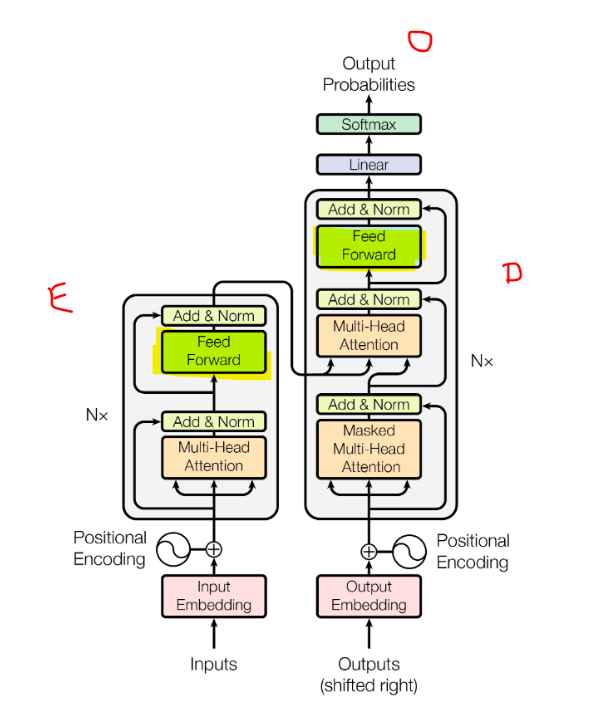

### **class PositionalEmbedding**


**Positional encoding** is important because it lets the model capture the order of the words in a sequence without using RNN or convolutional layers.

If tokens are processed simultaneosly and in parallel rather than sequentially, the model has no information about the position of a token in a sequence.

To solve this issue, the paper introduces sinusoidal positional encodings, which add a unique "position vector" to each token’s embedding. The vectors use sine and cosine functions to generate values that depend on the position and the embedding dimension.

In the sinusoidal method, each position is represented by a combination of sine and cosine functions at different frequencies, each position has a unique representation, positions closer together have similar encodings, helping the model learn sequential relationships in the data.

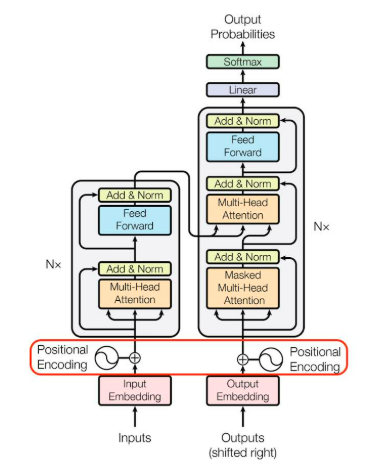

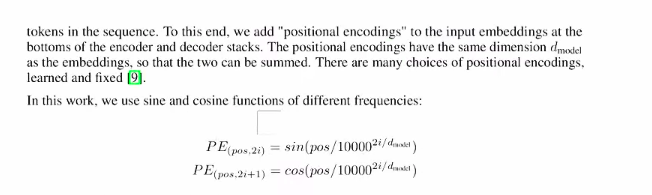

In [4]:
# Positional embedding for transformer models
# Adds positional information to token embeddings using sinusoidal functions
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_seq_len=MAX_SEQ_LEN):
        # d_model: dimensionality of the embedding (e.g., 512 for standard transformer models)
        # max_seq_len: maximum sequence length for embeddings

        super().__init__()

        # Initialize positional embedding matrix with zeros
        self.pos_embed_matrix = torch.zeros(max_seq_len, d_model, device=device)

        # Generate position indices for each token position in the sequence
        token_pos = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)

        # Calculate the denominator for the sinusoidal function
        # Sine for even indices and cosine for odd indices
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even indices and cosine to odd indices
        self.pos_embed_matrix[:, 0::2] = torch.sin(token_pos * div_term)
        self.pos_embed_matrix[:, 1::2] = torch.cos(token_pos * div_term)

        # Adjust matrix dimensions for broadcasting in forward pass
        self.pos_embed_matrix = self.pos_embed_matrix.unsqueeze(0).transpose(0, 1)

    def forward(self, x):
        # Adds positional encoding to input embeddings
        return x + self.pos_embed_matrix[:x.size(0), :]

### **class MultiHeadAttention**

This class is an implementation of the multihead attention mechanism described in the paper, it lets the transformer model focus on different parts of the sequence simultaneusly by using multiple heads or attention mechanisms in parallel

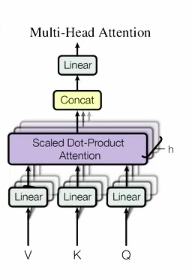

### **Key ecuations for attention**



*   Q = queries
*   K = keys
*   V = Values
*   W = Learned weight



**Scaled Dot-Product Attention**

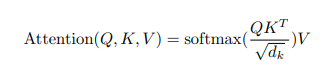

**Multi-head attention**

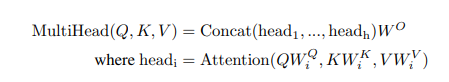

In [9]:
# Multi-Head Attention class for transformer layers
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=512, num_heads=8):
        # d_model: dimensionality of the embedding (must be divisible by num_heads)
        # num_heads: number of attention heads

        super().__init__()
        assert d_model % num_heads == 0, 'd_model must be divisible by num_heads'

        # Split the embedding into separate heads
        self.d_k = d_model // num_heads  # dimensionality per head
        self.num_heads = num_heads

        # Define linear layers for Q, K, and V projections
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)  # final linear layer

    def forward(self, Q, K, V, mask=None):
        # Q, K, V: query, key, and value matrices, each of shape [batch_size, seq_len, d_model]
        # mask: optional mask to prevent attention to certain tokens

        batch_size = Q.size(0)

        # Project Q, K, V and reshape for multi-head attention
        Q = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Compute scaled dot-product attention
        weighted_values, attention = self.scale_dot_product(Q, K, V, mask)

        # Concatenate attention heads and apply final linear transformation
        weighted_values = weighted_values.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        return self.W_o(weighted_values), attention

    def scale_dot_product(self, Q, K, V, mask=None):
        # Computes attention scores and applies softmax
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attention = F.softmax(scores, dim=-1)
        weighted_values = torch.matmul(attention, V)
        return weighted_values, attention

### **class PositionFeedForward**

This class has 2 linear layers with a ReLU activation function in between

In [10]:
# Feed-forward layer for transformer models
class PositionFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        # d_model: dimensionality of the input embedding
        # d_ff: hidden layer dimensionality in the feed-forward network

        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # Applies two linear transformations with ReLU activation
        return self.linear2(F.relu(self.linear1(x)))

### **class EncoderSubLayer**

This class represents a single building block of the Transformer encoder. Each Encoder Sub layer has a multi-head attention and a feed forward neural network.
This class also includes a normalization and dropout layers which help stabilize training and prevent overfitting.

In the model, encoder sub-layers are stacked for processing complex patterns in data.


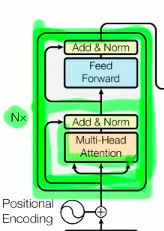

In [11]:
# Encoder layer block consisting of multi-head attention, feed-forward, and normalization
class EncoderSubLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # x: input to the encoder
        # mask: optional mask for attention

        attention_score, _ = self.self_attn(x, x, x, mask)
        x = x + self.dropout1(attention_score)  # add & normalize
        x = self.norm1(x)
        x = x + self.dropout2(self.ffn(x))  # feed forward, add & normalize
        return self.norm2(x)

### **class Encoder**

The encoder transforms the input data into a high-quality representation that captures the meaning of the structure of the entire sequence, then it is passed to the decoder .

This class has a series of stacked Encoder sub-layers. Each layer improves the understanding of the input by repeating a combination of multi-head attention and feedforward layers

It has a final layer for normalization

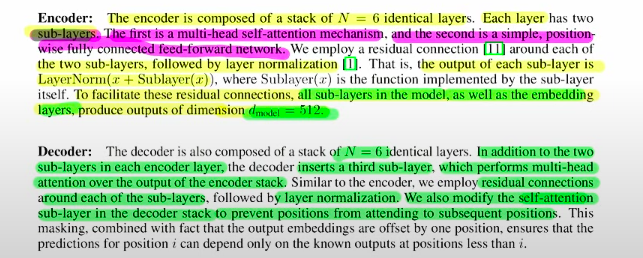

In [12]:
# Encoder class with multiple encoder layers and final normalization
class Encoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, dropout=0.1):
        super().__init__()
        # Stacks `num_layers` of encoder sub-layers
        self.layers = nn.ModuleList([EncoderSubLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        # Passes input through each encoder layer
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)  # final layer normalization

### **class DecoderSubLayer**

This class represents a single layer in the Transformer decoder and is responsible for generating the target sequence

Its main pars are:

* Masked multi-head attention: allows each position in the target sequence to attend only to previous positions and itself to prevent looking ahead at future tokens.
* Cross-attention with Encoder output: allows each token in the target sequence to attend all tokens in the encoder input linking the generated tokens to the context of the input sequence.
* Feedforward: After the attention steps each token representation is passed through a feedforward network to capture richer patterns

Normalization and dropout layers are applied at the end for stabilizing training.

In [13]:
# Decoder layer with multi-head attention, cross-attention, feed-forward, and normalization
class DecoderSubLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)  # self-attention
        self.cross_attn = MultiHeadAttention(d_model, num_heads)  # encoder-decoder cross-attention
        self.feed_forward = PositionFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, encoder_output, target_mask=None, encoder_mask=None):
        # x: decoder input
        # encoder_output: output from the encoder
        # target_mask: mask for self-attention
        # encoder_mask: mask for encoder-decoder attention

        # apply multi-head self-attention to x
        # target mask ensures that model can't attend tokens that come after the current position
        attention_score, _ = self.self_attn(x, x, x, target_mask)
        # the result of the self-attention is added back to x
        # dropout is applied for regulatization
        x = x + self.dropout1(attention_score)
        # this layer stabilizes the training process
        x = self.norm1(x)

        encoder_attn, _ = self.cross_attn(x, encoder_output, encoder_output, encoder_mask)
        x = x + self.dropout2(encoder_attn)
        x = self.norm2(x)

        ff_output = self.feed_forward(x)
        x = x + self.dropout3(ff_output)
        return self.norm3(x)

### **class Decoder**

This class processes the target sequence (e.g. a sentence in another language) and progresively refine it, layer by layer, using the output of the encoder to produce the final sequence.

In [14]:
# Decoder with multiple decoder layers and final normalization
class Decoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([DecoderSubLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, encoder_output, target_mask, encoder_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, target_mask, encoder_mask)
        return self.norm(x)  # final layer normalization


## **Transformer**

This class represents the full Transformer model, combining the encoder and the decoder for an end-to-end sequence transformation.

In [15]:
class Transformer(nn.Module):
    # Initialize the main components of the Transformer model.

    # d_model: Dimensionality of embeddings.
    # num_heads: Number of attention heads in multi-head attention.
    # d_ff: Size of the feed-forward layer in each encoder/decoder layer.
    # num_layers: Number of encoder and decoder layers.
    # input_vocab_size: Size of the source language vocabulary.
    # target_vocab_size: Size of the target language vocabulary.
    # max_len: Maximum length of input sequences (default=MAX_SEQ_LEN).
    # dropout: Dropout rate to prevent overfitting.

    def __init__(self, d_model, num_heads, d_ff, num_layers,
                 input_vocab_size, target_vocab_size,
                 max_len=MAX_SEQ_LEN, dropout=0.1):
        super().__init__()

        # Embedding layer for source language tokens.
        self.encoder_embedding = nn.Embedding(input_vocab_size, d_model)

        # Embedding layer for target language tokens.
        self.decoder_embedding = nn.Embedding(target_vocab_size, d_model)

        # Token position information.
        self.pos_embedding = PositionalEmbedding(d_model, max_len)

        # Encoder
        self.encoder = Encoder(d_model, num_heads, d_ff, num_layers, dropout)

        # Decoder
        self.decoder = Decoder(d_model, num_heads, d_ff, num_layers, dropout)

        # Linear layer to map decoder output to target vocabulary size.
        self.output_layer = nn.Linear(d_model, target_vocab_size)

    def forward(self, source, target):
        # Generates the output sequence for a given input sequence.


        # Create masks for padding tokens in source and target sequences.
        source_mask, target_mask = self.mask(source, target)

        # Encode source sequence: apply embedding, scaling, and positional encoding.
        source = self.encoder_embedding(source) * math.sqrt(self.encoder_embedding.embedding_dim)
        source = self.pos_embedding(source)  # Add positional encodings.

        # Pass encoded source through the encoder layers.
        encoder_output = self.encoder(source, source_mask)

        # Decode target sequence: apply embedding, scaling, and positional encoding.
        target = self.decoder_embedding(target) * math.sqrt(self.decoder_embedding.embedding_dim)
        target = self.pos_embedding(target)  # Add positional encodings.

        # Pass target and encoder output through decoder layers.
        output = self.decoder(target, encoder_output, target_mask, source_mask)

        # Map decoder output to the target vocabulary for prediction.
        return self.output_layer(output)

    def mask(self, source, target):
        # Create masks to prevent the model from attending to padding tokens and future tokens in the target.

        # Source mask to ignore padding tokens (0 represents padding).
        source_mask = (source != 0).unsqueeze(1).unsqueeze(2)

        # Target mask to ignore padding and prevent attending to future tokens.
        target_mask = (target != 0).unsqueeze(1).unsqueeze(2)

        # Create a lower-triangular matrix to prevent attending to future tokens.
        size = target.size(1)
        no_mask = torch.tril(torch.ones((1, size, size), device=device)).bool()

        # Combine masks for future tokens and padding tokens.
        target_mask = target_mask & no_mask
        return source_mask, target_mask


#### Simple test

Now that our Transformer model is ready, we run a simple test to ensure the implementation of the architecture is correct. This test consists of performing a forward pass through the model with a small fake input and target; and then validating that the output dimensions are the ones we expect.

In [16]:
seq_len_source = 10 # Length of the input language
seq_len_target = 10 #Lenght of the target language
batch_size = 2 # Sequences per batch
input_vocab_size = 50 # Size of the source vocuabulary
target_vocab_size = 50 # Size of the target vocabulary

source = torch.randint(1, input_vocab_size, (batch_size, seq_len_source)) #Makes the batch of token sequences for source language
target = torch.randint(1, target_vocab_size, (batch_size, seq_len_target)) #Makes the batch of token sequences for target language

In [17]:
d_model = 512 #Embeddings dimensionality
num_heads = 8 #Number of heads
d_ff = 2048 # Size feedforward layer
num_layers = 6 #Number of blocks

#Instantiate the Transformer Model
model = Transformer(d_model, num_heads, d_ff, num_layers,
                  input_vocab_size, target_vocab_size,
                  max_len=MAX_SEQ_LEN, dropout=0.1)


model = model.to(device)
source = source.to(device)
target = target.to(device)

In [18]:
output = model(source, target)

In [19]:
# Expected output shape -> [batch, seq_len_target, target_vocab_size] i.e. [2, 10, 50]
print(f'ouput.shape {output.shape}')

ouput.shape torch.Size([2, 10, 50])


## **Eng-Spa Translator**

**Set path to translation file**

In [ ]:
#Route of the dataset (Spanish/English)
PATH = '/content/drive/MyDrive/Spa_Eng_sentences.txt'

**Open file and process it**

In [ ]:
#Open the file and make pairs (Spanish/English)
with open(PATH, 'r', encoding='utf-8') as f:
    lines = f.readlines()
eng_spa_pairs = [line.strip().split('\t') for line in lines if '\t' in line]

**Print a sample of the processed content**

In [ ]:
#Print the first 10 items of the pairs list
eng_spa_pairs[:10]

[['S\x92.', 'Yep.'],
 ['Ve.', 'Go.'],
 ['Ya.', 'Come now.'],
 ['No.', 'Nay.'],
 ['S\x8e.', 'I know.'],
 ['Ay.', 'Alas.'],
 ['No.', 'No.'],
 ['No.', 'Nope.'],
 ['ÀY?', 'And?'],
 ['ÀY?', 'So?']]

**Split lists into english and spanish lists**

In [ ]:
#Split the sentences in two separate lists -spanish and English-
spa_sentences = [pair[0] for pair in eng_spa_pairs]
eng_sentences = [pair[1] for pair in eng_spa_pairs]

**Print a sample of both lists**

In [ ]:
#Print the first words for each list
print(eng_sentences[:10])
print(spa_sentences[:10])


['Yep.', 'Go.', 'Come now.', 'Nay.', 'I know.', 'Alas.', 'No.', 'Nope.', 'And?', 'So?']
['S\x92.', 'Ve.', 'Ya.', 'No.', 'S\x8e.', 'Ay.', 'No.', 'No.', 'ÀY?', 'ÀY?']


In [ ]:
# Filtering Non-Alphabetical Characters
# Removing Accented Characters
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[á]+", "a", sentence)
    sentence = re.sub(r"[é]+", "e", sentence)
    sentence = re.sub(r"[í]+", "i", sentence)
    sentence = re.sub(r"[ó]+", "o", sentence)
    sentence = re.sub(r"[ú]+", "u", sentence)
    sentence = re.sub(r"[^a-z]+", " ", sentence)
    sentence = sentence.strip()
    sentence = '<sos> ' + sentence + ' <eos>'
    return sentence

In [ ]:
# Example Sentence
s1 = '¿Hola @ cómo estás? 123'

In [ ]:
# Senteces processed
print(s1)
print(preprocess_sentence(s1))

¿Hola @ cómo estás? 123
<sos> hola como estas <eos>


In [ ]:
# Perform the cleaning for each sentence
eng_sentences = [preprocess_sentence(sentence) for sentence in eng_sentences]
spa_sentences = [preprocess_sentence(sentence) for sentence in spa_sentences]

In [ ]:
#Print first 10 English senteces
eng_sentences[:10]

['<sos> yep <eos>',
 '<sos> go <eos>',
 '<sos> come now <eos>',
 '<sos> nay <eos>',
 '<sos> i know <eos>',
 '<sos> alas <eos>',
 '<sos> no <eos>',
 '<sos> nope <eos>',
 '<sos> and <eos>',
 '<sos> so <eos>']

In [ ]:
#Print first 10 Spanish senteces
spa_sentences[:10]

['<sos> s <eos>',
 '<sos> ve <eos>',
 '<sos> ya <eos>',
 '<sos> no <eos>',
 '<sos> s <eos>',
 '<sos> ay <eos>',
 '<sos> no <eos>',
 '<sos> no <eos>',
 '<sos> y <eos>',
 '<sos> y <eos>']

**build_vocab()** creates a vocabulary dictionary by assinging and index to each unique token in the dataset

In [ ]:
def build_vocab(sentences):
    # List of words
    words = [word for sentence in sentences for word in sentence.split()]

    # Frequency of each word in the list
    word_count = Counter(words)

    # Sort words by frequency in descending order
    sorted_word_counts = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
    word2idx = {word: idx for idx, (word, _) in enumerate(sorted_word_counts, 2)}


    word2idx['<pad>'] = 0  # Padding token
    word2idx['<unk>'] = 1  # Unknown word token

    # Create a reverse mapping (index-to-word)
    idx2word = {idx: word for word, idx in word2idx.items()}

    return word2idx, idx2word

In [ ]:
eng_word2idx, eng_idx2word = build_vocab(eng_sentences)  # English vocab mappings
spa_word2idx, spa_idx2word = build_vocab(spa_sentences) # Spanish vocab mappings
eng_vocab_size = len(eng_word2idx)
spa_vocab_size = len(spa_word2idx)

In [ ]:
print(eng_vocab_size, spa_vocab_size) #Length of the english vocabulary
                                      # and the spanish vocabulary.

27707 44207


**class EngSpaDataset**

Handlers english-spanish sentence pairs
It inherits from PyTorch DataSet class and is structured to make English and Spanish sentences available in a format the model can use during training

In [ ]:
class EngSpaDataset(Dataset):
    def __init__(self, eng_sentences, spa_sentences, eng_word2idx, spa_word2idx):

        self.eng_sentences = eng_sentences # List of preprocessed English sentences
        self.spa_sentences = spa_sentences #List of preprocessed Spanish sentences
        self.eng_word2idx = eng_word2idx # Dictionary mapping English words to indices
        self.spa_word2idx = spa_word2idx # Dictionary mapping Spanish words to indices.

    def __len__(self):
        return len(self.eng_sentences)

    def __getitem__(self, idx):
        eng_sentence = self.eng_sentences[idx]
        spa_sentence = self.spa_sentences[idx]
        # return tokens idxs

        # Convert English sentence to token indices using eng_word2idx dictionary
        eng_idxs = [self.eng_word2idx.get(word, self.eng_word2idx['<unk>']) for word in eng_sentence.split()]
        # Convert Spanish sentence to token indices using spa_word2idx dictionary
        spa_idxs = [self.spa_word2idx.get(word, self.spa_word2idx['<unk>']) for word in spa_sentence.split()]

        return torch.tensor(eng_idxs), torch.tensor(spa_idxs)

**collate_fn()** stardardizes each batch to the same length making them compatible with matrix-based computations in the model.

In [ ]:
def collate_fn(batch):
    # Unzip the batch into English and Spanish sentences
    eng_batch, spa_batch = zip(*batch)
    eng_batch = [seq[:MAX_SEQ_LEN].clone().detach() for seq in eng_batch]
    spa_batch = [seq[:MAX_SEQ_LEN].clone().detach() for seq in spa_batch]

    # Return the padded tensors for both English and Spanish
    eng_batch = torch.nn.utils.rnn.pad_sequence(eng_batch, batch_first=True, padding_value=0)
    spa_batch = torch.nn.utils.rnn.pad_sequence(spa_batch, batch_first=True, padding_value=0)
    return eng_batch, spa_batch


**train()** is responsible for training the Transformer model using the provided data. It executes the training loop for a specified number of epochs.

In [ ]:
def train(model, dataloader, loss_function, optimiser, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        # Iterate over batches in the dataloader
        for i, (eng_batch, spa_batch) in enumerate(dataloader):
            eng_batch = eng_batch.to(device)
            spa_batch = spa_batch.to(device)
            # Decoder preprocessing
            target_input = spa_batch[:, :-1]
            target_output = spa_batch[:, 1:].contiguous().view(-1)
            # Zero grads
            optimiser.zero_grad()
            # run model
            output = model(eng_batch, target_input)
            output = output.view(-1, output.size(-1))
            # loss\
            loss = loss_function(output, target_output)
            # gradient and update parameters
            loss.backward()
            optimiser.step()
            total_loss += loss.item()

        #average loss for the epoch
        avg_loss = total_loss/len(dataloader)
        print(f'Epoch: {epoch}/{epochs}, Loss: {avg_loss:.4f}')

In [ ]:
BATCH_SIZE = 64 #Batch size
dataset = EngSpaDataset(eng_sentences, spa_sentences, eng_word2idx, spa_word2idx) # EngSpaDataset is instantiated with the English and Spanish sentences
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn) # # Initialize DataLoader

**Instantiate the Transformer model**

In [ ]:
model = Transformer(d_model=512, num_heads=8, d_ff=2048, num_layers=6,
                    input_vocab_size=eng_vocab_size, target_vocab_size=spa_vocab_size,
                    max_len=MAX_SEQ_LEN, dropout=0.1)

**Instantiate a loss function and an optimizer**

In [ ]:
model = model.to(device)
loss_function = nn.CrossEntropyLoss(ignore_index=0) #CrossEntropyLoss with padding token index as 0
optimiser = optim.Adam(model.parameters(), lr=0.0001) #Use Adam as optimiser

**Train the model**

In [ ]:
train(model, dataloader, loss_function, optimiser, epochs = 10) #Start training the model - 10 Epochs

Epoch: 0/10, Loss: 3.5096
Epoch: 1/10, Loss: 2.1306
Epoch: 2/10, Loss: 1.6472
Epoch: 3/10, Loss: 1.3313
Epoch: 4/10, Loss: 1.0922
Epoch: 5/10, Loss: 0.8991
Epoch: 6/10, Loss: 0.7423
Epoch: 7/10, Loss: 0.6191
Epoch: 8/10, Loss: 0.5274
Epoch: 9/10, Loss: 0.4604


In [ ]:
# Save model state dictionary
torch.save(model.state_dict(), '/content/drive/MyDrive/model_weights.pth')

# Save the entire model
torch.save(model, '/content/drive/MyDrive/full_model.pth')


**sentence_to_indices()** converts the processed sentence into a sequence of indices based on the vocabulary. This is used to transform a raw input sentence in English into a vector representation that can be read by our model. If for some reason the sentence contains a word that is not part of our dictionary, it will be replaced by the '\<unk\>' token.

In [ ]:
def sentence_to_indices(sentence, word2idx):
    return [word2idx.get(word, word2idx['<unk>']) for word in sentence.split()]

**indices_to_sentence(**) reverses the process of sentence_to_indices(). As such, this is used to convert the indices of each word predicted by our model into an actual Spanish word.

In [ ]:
def indices_to_sentence(indices, idx2word):
    return ' '.join([idx2word[idx] for idx in indices if idx in idx2word and idx2word[idx] != '<pad>'])

**translate_sentence()** translates a given sentence using the trained model; it takes an input sentence, converts it to indices, passes it to the model to get a translated sequence, and then converts the sentence to a readable sentence.

The actual translation works by calling the transformer model to predict the most likely next token in the target sequence based on the input sentence and the output tokens predicted so far. This prediction is repeated until we reach `MAX_SEQ_LEN` iterations or when the model predicts an end-of-sentence '\<eos\>' token, whichever happens first.

In [ ]:
def translate_sentence(model, sentence, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device='cpu'):
    model.eval()
    sentence = preprocess_sentence(sentence)
    input_indices = sentence_to_indices(sentence, eng_word2idx)
    input_tensor = torch.tensor(input_indices).unsqueeze(0).to(device)

    # Initialize the target tensor with <sos> token
    tgt_indices = [spa_word2idx['<sos>']]
    tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(max_len):
            output = model(input_tensor, tgt_tensor)
            output = output.squeeze(0)
            next_token = output.argmax(dim=-1)[-1].item()
            tgt_indices.append(next_token)
            tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0).to(device)
            if next_token == spa_word2idx['<eos>']:
                break

    return indices_to_sentence(tgt_indices, spa_idx2word)

**evaluate_translations()** asseses the model's performance by comparing its generated translations to the reference translation.

In [ ]:
def evaluate_translations(model, sentences, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device='cpu'):
    for sentence in sentences:
        translation = translate_sentence(model, sentence, eng_word2idx, spa_idx2word, max_len, device)
        print(f'Input sentence: {sentence}')
        print(f'Traducción: {translation}')
        print()

In [ ]:
# Example sentences to test the translator
test_sentences = [
    "My favorite color is blue",
    "I love my new watch",
    "Today is Tuesday",
    "I have two brothers",
    "Donald Trump is the new president",
    "I hate to wake up early",
    "Tell me your name",
    "This afternoon was cloudy",
    "There are many wild animals out of my yard",
    "I like to eat pizza",
    "I hate vegetables for dinner",
    "I feel really sick",

]

# Assuming the model is trained and loaded
# Set the device to 'cpu' or 'cuda' as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Evaluate translations
evaluate_translations(model, test_sentences, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device=device)


Input sentence: My favorite color is blue
Traducción: <sos> mi color favorito es el azul <eos>

Input sentence: I love my new watch
Traducción: <sos> me encanta mi nuevo reloj <eos>

Input sentence: Today is Tuesday
Traducción: <sos> hoy es martes <eos>

Input sentence: I have two brothers
Traducción: <sos> tengo dos hermanos <eos>

Input sentence: Donald Trump is the new president
Traducción: <sos> donald trump es el nuevo presidente <eos>

Input sentence: I hate to wake up early
Traducción: <sos> odio levantarme temprano <eos>

Input sentence: Tell me your name
Traducción: <sos> dime tu nombre <eos>

Input sentence: This afternoon was cloudy
Traducción: <sos> esta tarde estuvo nublado <eos>

Input sentence: There are many wild animals out of my yard
Traducción: <sos> hay muchos animales salvajes en mi patio trasero <eos>

Input sentence: I like to eat pizza
Traducción: <sos> me gusta comer pizza <eos>

Input sentence: I hate vegetables for dinner
Traducción: <sos> odio las verduras p

## **Conclusions**

This activity showcases an implementation of a Transformer model as defined in the aforementioned paper, Attention Is All You Need. As the name of the paper implies, the defining characteristic of the Transformer model is the usage of self-attention, the implementation of which is captured in the `MultiHeadAttention` class. Crucially, this is used to implement the concept of cross attention in the Decoder, which makes it possible to contextualize the target sequence with all the tokens in the input sequence.

With this clever usage of self-attention, the Transformer model achieved great improvements in training times compared to previous models, mostly due to the increase in parallelization.

To validate our implementation of the Transformer architecture, a model for translating sentences from English to Spanish was trained on it, using roughly 266K sentences samples from Tatoeba. After training was completed, which did take a lot of time with the limited compute available in the free tier of Google Colab; the model is now able to successfully translate simple sentences, even if the training set would be considered small for state of the art models.

By completing this excercise, we gained a better understanding and appreciation for the recent advances in the field of LLMs, which in the current day are somewhat easy to take for granted. Not only this puts into perspective how many resources are necessary to train even the smaller models, which are much larger than the one we trained; but also provides a great insight into how this process and the models actually work.

